In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [6]:
batch_size = 64

image_classes = ['cored', 'diffuse', 'CAA']

In [7]:
test = pd.read_csv(os.path.join(cfg.csv_dir, 'test_multilabel.csv'))

In [8]:
np.random.seed(42)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
src_test = (ImageList.from_df(path=cfg.img_path_test, df=test, folder='hold-out')
       .split_none()
       .label_from_df(label_delim=' '))

In [9]:
data_test = (src_test.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
resnet = models.resnet50
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data_test, resnet, metrics=[acc_05, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.4MB/s]


In [10]:
model_name = 'stage-8-256-rn50'

In [11]:
learn = learn.load(os.path.join(cfg.models_dir, model_name))

In [ ]:
learn.data.valid_dl = data_test.train_dl
learn.validate(metrics=[acc_05, f_score])

In [ ]:
learn.show_results()

In [ ]:
preds, y, losses = learn.get_preds(with_loss=True)

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    fig = plt.figure(figsize=(1.2*size, size))
    ax = plt.axes()
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())
        lw = 0.2*size
        # Plot all ROC curves
        ax.plot([0, 1], [0, 1], 'k--', lw=lw, label='random')
        ax.plot(fpr, tpr,
                 label='ROC-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(fpr, tpr)),
                  color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)
       
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=1.8*size)
    ax.set_ylabel('True Positive Rate', fontsize=1.8*size)
    ax.set_title('Receiver operating characteristic Curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc=0, fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

    
def plot_prc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    
    fig = plt.figure(figsize=(1.2*size,size))
    ax = plt.axes()
    
    for i in range(preds.shape[1]):
        rp = (label[:,i]>0).sum()/len(label)
        precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
        
        lw=0.2*size
    
        ax.plot(recall, precision,
                 label='PR-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(recall, precision)),
                 color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)

        ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
   
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=1.8*size)
    ax.set_ylabel('Precision', fontsize=1.8*size)
    ax.set_title('Precision-Recall curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc="lower left", bbox_to_anchor=(0.01, 0.1), fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

In [ ]:
plot_roc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_roc_plot.png'))
plot_prc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_prc_plot.png'))

In [27]:
l = losses.numpy()
losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/4), 4)), columns=learn.data.classes)
losses_df

,CAA,cored,diffuse,negative
0,2.268296e-04,6.627817e-05,0.313917,0.258811
1,1.443520e-04,4.660974e-05,0.012082,0.015307
2,7.152555e-07,1.023955e-04,0.000360,0.001376
3,1.963184e-04,1.299373e-05,0.029475,0.030210
4,4.756338e-05,2.384186e-07,0.008193,0.010937
...,...,...,...,...
10811,1.203941e-04,3.576278e-07,0.001904,0.003686
10812,1.381540e-04,8.937592e-03,0.001157,0.006434
10813,1.680837e-05,8.344647e-07,0.005096,0.007578
10814,1.192093e-07,1.192093e-07,0.000218,0.000267


In [153]:
def losses_reshape(losses, classes=[]):
    l = losses.numpy()
    n_classes = len(classes)
    losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/n_classes), n_classes)),
                             columns=classes)
    return(losses_df)

def get_top_agg_losses(df, n=10):
    
    df['loss'] = pd.DataFrame(df.sum(axis=1), columns=['loss'])
    df = df.sort_values(['loss'], ascending=False)
    
    return(df.iloc[0:n])

def plot_top_losses(preds=None,
                    y=None,
                    losses=None,
                    learner=None,
                    n=10,
                    figsize=(8,8)):
    classes=learn.data.classes
    losses_df = losses_reshape(losses, classes=classes)
    losses_df = get_top_agg_losses(losses_df, n=n)
    preds_df = pd.DataFrame(preds.numpy(), columns=classes)
    y_df = pd.DataFrame(y.numpy(), columns=classes)
    classes_str = ', '.join(classes)
    for index_i in losses_df.index:
        imag = learner.data.valid_ds[index_i][0]
        predictions =', '.join(["{0:.4f}".format(x) for x in preds_df.iloc[index_i].values])
        actuals = ', '.join(["{}".format(x) for x in y_df.iloc[index_i].values])
        imag = show_image(imag, figsize=figsize)
        imag.set_title(f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}""",
                        loc='left')
        plt.show()
        
    
    return(losses_df)
    
    
    

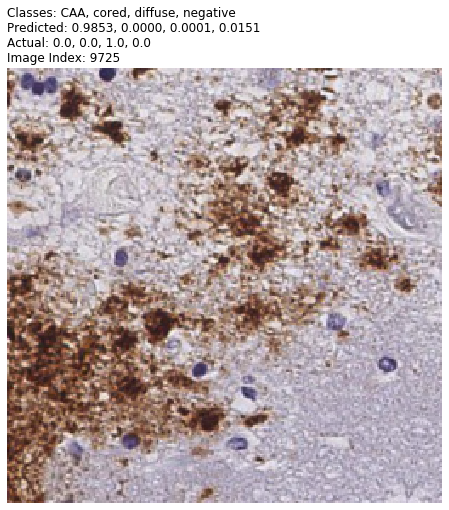

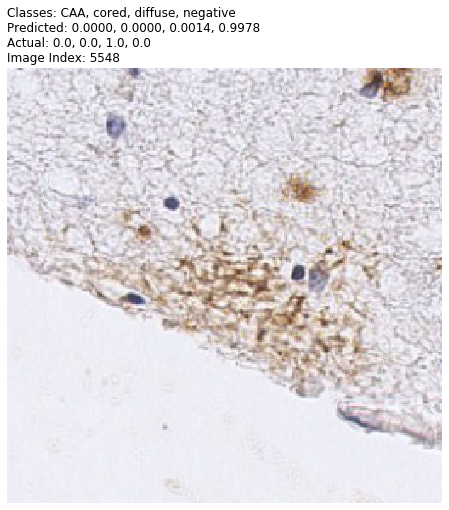

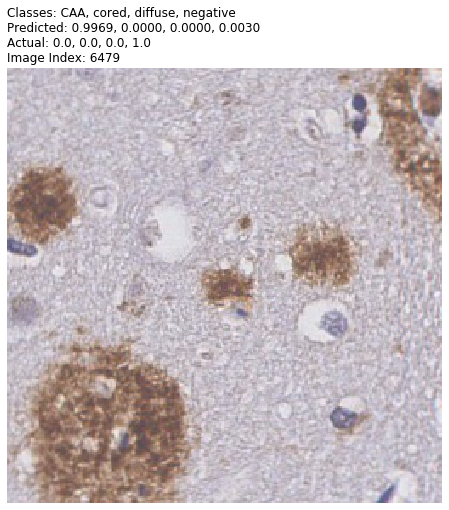

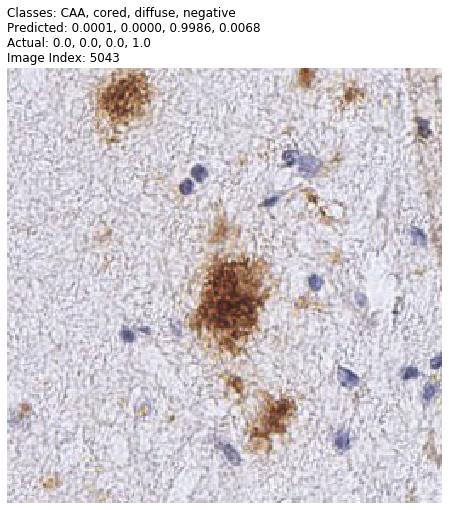

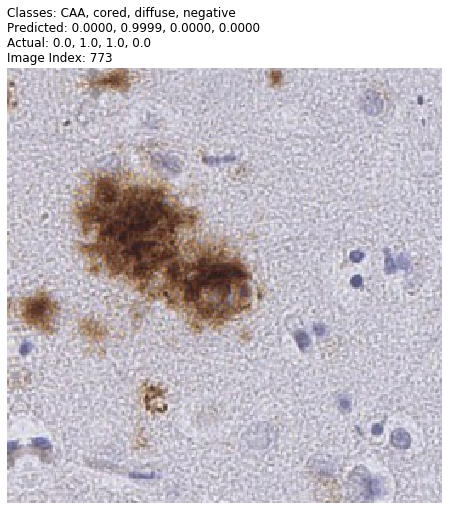

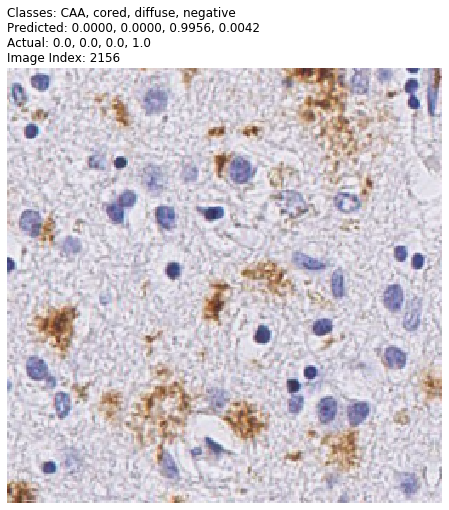

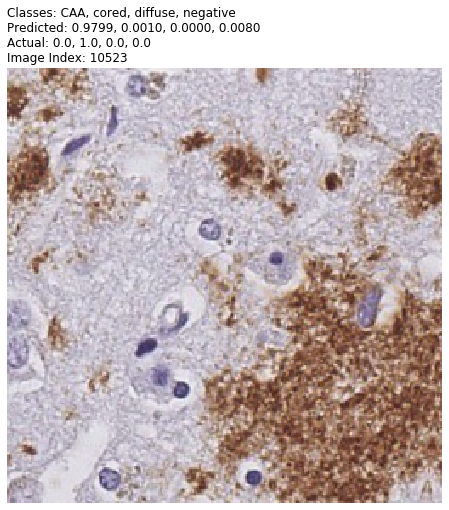

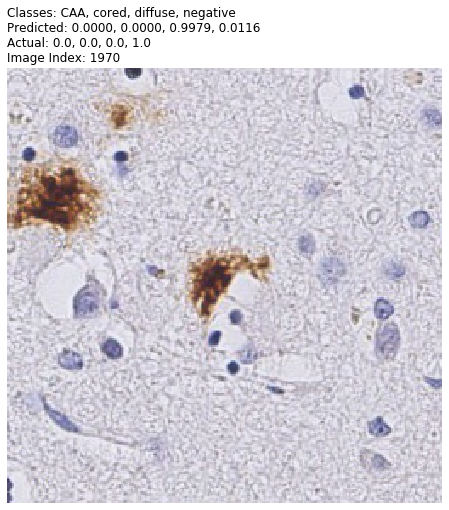

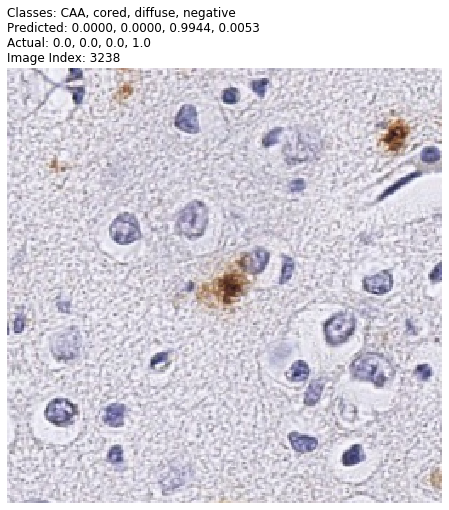

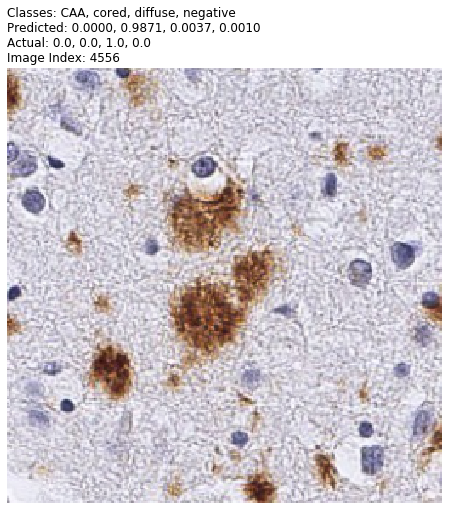

,CAA,cored,diffuse,negative,loss
9725,4.217797e+00,7.867782e-06,9.015453,1.516855e-02,13.248425
5548,1.311301e-06,1.311301e-06,6.591816,6.114677e+00,12.706495
6479,5.778759e+00,1.549720e-06,0.000014,5.797215e+00,11.575990
5043,5.090107e-05,3.862306e-05,6.576062,4.995559e+00,11.571711
773,2.384186e-07,1.007268e-04,11.422346,8.344647e-07,11.422448
2156,3.361646e-05,7.152555e-07,5.415253,5.478824e+00,10.894111
10523,3.907096e+00,6.906926e+00,0.000035,7.999644e-03,10.822057
1970,1.204007e-05,1.192093e-07,6.169864,4.460900e+00,10.630775
3238,1.072878e-05,1.764282e-05,5.188465,5.237287e+00,10.425779
4556,1.764282e-05,4.352806e+00,5.588033,1.029915e-03,9.941887


In [154]:
plot_top_losses(preds=preds,
                    y=y,
                    losses=losses,
                    learner=learn)